In [1]:
import xarray as xr
import pandas as pd

ds_sat= xr.open_dataset('LGMR_data/ds_sat_flipped.nc')
df_pre= pd.read_csv(r"D:\VScode\Inso_LGMR\inso_data\pre.csv")
ds_sat_ens= xr.open_dataset('LGMR_data/ds_sat_ens_flipped.nc')

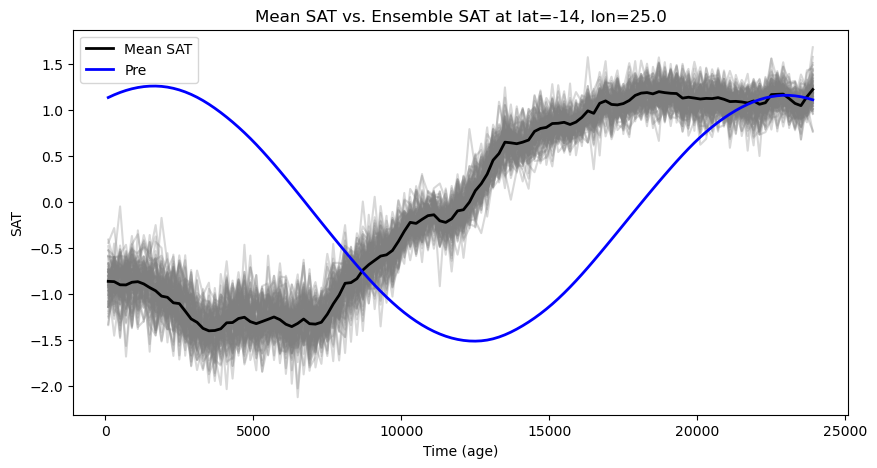

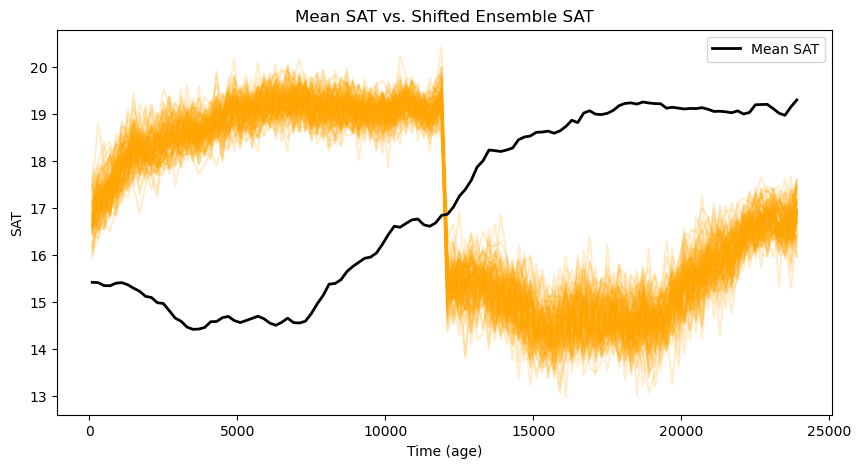

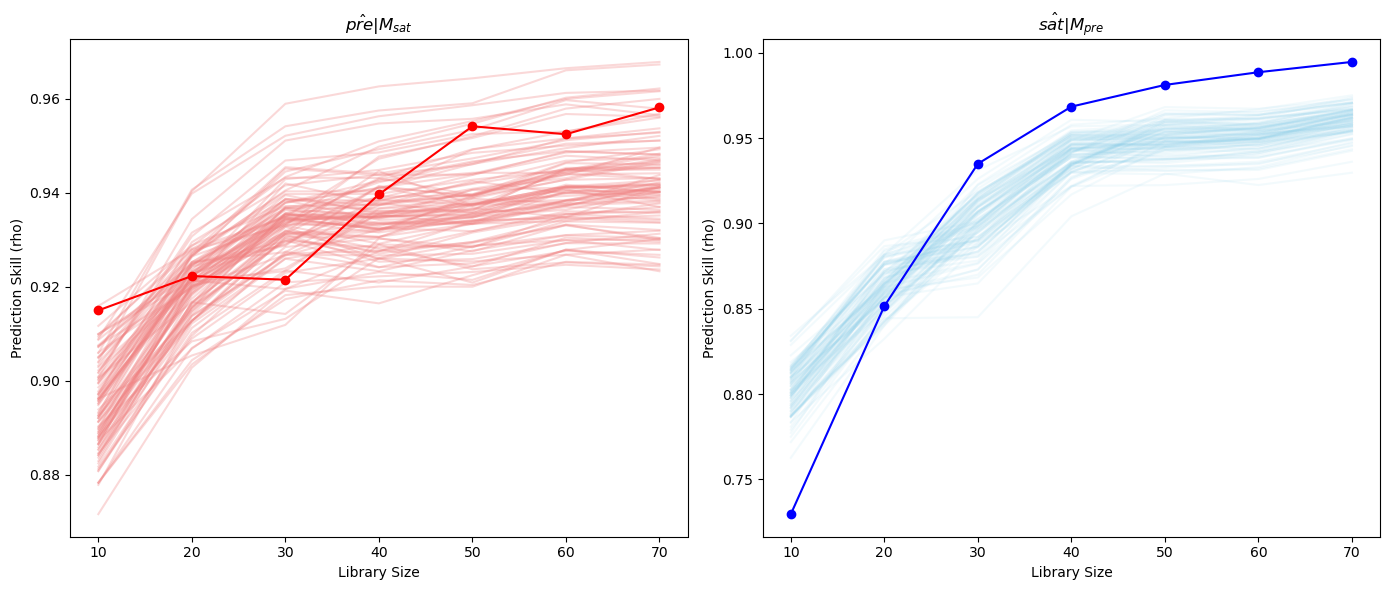

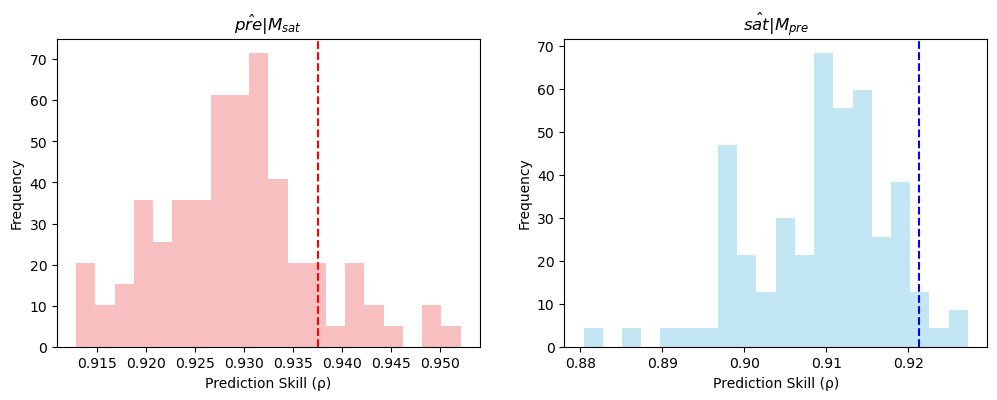

False


In [ ]:
import numpy as np
import xarray as xr
import pandas as pd
from toolbox import significant_test as st
import importlib
importlib.reload(st)



results = st.ccm_significance_statistic(
    ds_sat= ds_sat,
    df_pre= df_pre,
    ds_sat_ens= ds_sat_ens,
    lat_idx=40,
    lon_idx=10,
    ens_sample=100,
    E_val=4,
    tau_val=3,
    Tp_val=-15,
    libSizes="10 20 30 40 50 60 70",
    show_figures=True
)

ccm_out = results["ccm_mean"]
ensemble_ccm = results["ensemble_ccm"]

test_result = st.ccm_significance_test(ccm_out, ensemble_ccm, if_plot=True)
print(test_result)


In [22]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyEDM import CCM
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from toolbox import significant_test as st
import importlib
importlib.reload(st)



def global_ccm_significance_map(ds_sat, df_pre, ds_sat_ens, samples, 
                                E_val, tau_val, Tp_val, libSizes, show_figures=False):
    """
    Loop over all grid points in ds_sat and ds_sat_ens, compute the CCM analysis and significance
    test for each grid point, and then plot a global map (Robinson projection) with coastlines
    overlaying the boolean significance results.
    
    Parameters:
      ds_sat     : xarray.Dataset with mean SAT data.
      df_pre     : pandas.DataFrame with pre data.
      ds_sat_ens : xarray.Dataset with ensemble SAT data.
      samples    : int, number of ensemble members to use.
      E_val, tau_val, Tp_val, libSizes : CCM parameters.
      show_figures: bool, if True, intermediate plots (per grid point) are shown.
    
    Returns:
      significance_map : 2D boolean numpy array (shape: [nlat, nlon]) with True/False significance.
    """
    nlat = ds_sat.sizes["lat"]
    nlon = ds_sat.sizes["lon"]
    significance_map = np.full((nlat, nlon), False, dtype=bool)
    
    # Loop over every grid point.
    for i in range(nlat):
        for j in range(nlon):
            # Suppress plotting during per–grid–point analysis
            results = st.ccm_significance_statistic(ds_sat, df_pre, ds_sat_ens, lat_idx=i, lon_idx=j, 
                                       samples=samples, E_val=E_val, tau_val=tau_val, Tp_val=Tp_val,
                                       libSizes=libSizes, show_figures=False)
            ccm_mean = results["ccm_mean"]
            ensemble_ccm = results["ensemble_ccm"]
            test_result = st.ccm_significance_test(ccm_mean, ensemble_ccm, if_plot=False)
            significance_map[i, j] = test_result
            print(f"Processed grid point: lat index={i}, lon index={j}, significance={test_result}")
    
    # Plot the global map
    lats = ds_sat["lat"].values
    lons = ds_sat["lon"].values
    lon_grid, lat_grid = np.meshgrid(lons, lats)
    
    fig = plt.figure(figsize=(12, 6))
    ax = plt.axes(projection=ccrs.Robinson())
    ax.coastlines()
    pcm = ax.pcolormesh(lon_grid, lat_grid, significance_map.astype(int),
                        transform=ccrs.PlateCarree(), cmap=plt.cm.Reds, vmin=0, vmax=1)
    cb = plt.colorbar(pcm, ax=ax, orientation="horizontal", pad=0.05)
    cb.set_label("Significance (1: True, 0: False)")
    ax.set_title("Global CCM Significance Map")
    plt.show()
    
    return significance_map




Processed grid point: lat index=0, lon index=0, significance=True
Processed grid point: lat index=0, lon index=1, significance=True
Processed grid point: lat index=0, lon index=2, significance=True
Processed grid point: lat index=0, lon index=3, significance=True
Processed grid point: lat index=0, lon index=4, significance=True
Processed grid point: lat index=0, lon index=5, significance=True
Processed grid point: lat index=0, lon index=6, significance=True
Processed grid point: lat index=0, lon index=7, significance=True
Processed grid point: lat index=0, lon index=8, significance=True
Processed grid point: lat index=0, lon index=9, significance=True
Processed grid point: lat index=0, lon index=10, significance=True
Processed grid point: lat index=0, lon index=11, significance=True
Processed grid point: lat index=0, lon index=12, significance=True
Processed grid point: lat index=0, lon index=13, significance=True
Processed grid point: lat index=0, lon index=14, significance=True
Proce

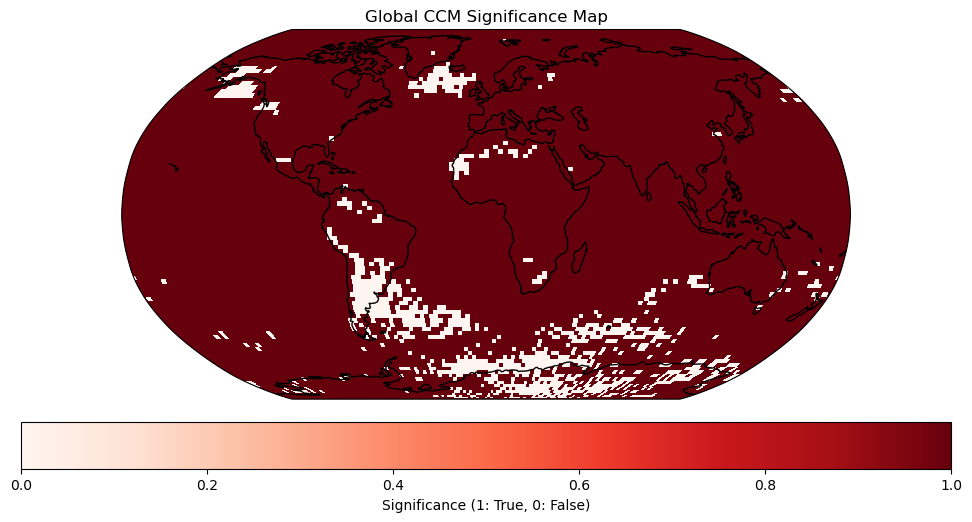

In [16]:

# First, run the global analysis over all grid points.
global_significance = global_ccm_significance_map(
    ds_sat =ds_sat,
    df_pre = df_pre,
    ds_sat_ens = ds_sat_ens,
    samples = 5,
    E_val = 4,
    tau_val = 3,
    Tp_val = 0,
    libSizes = "10 20 30 40 50 60 70",
    show_figures = False
)


In [18]:
# save global_significance using pickle to output folder
import pickle
with open("output/global_significance.pkl", "wb") as f:
    pickle.dump(global_significance, f)

d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


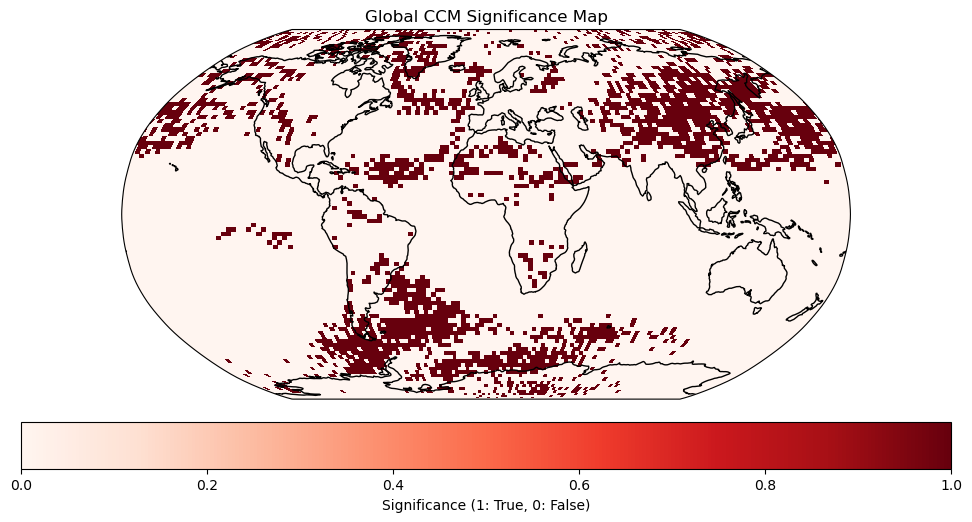

In [6]:
# Plot the global map

ds_sat = xr.open_dataset('LGMR_data/LGMR_SAT_climo.nc')
df_pre = pd.read_csv(r"D:\VScode\Inso_LGMR\inso_data\pre.csv")
ds_sat_ens = xr.open_dataset('LGMR_data/LGMR_SAT_ens.nc')

lats = ds_sat["lat"].values
lons = ds_sat["lon"].values
lon_grid, lat_grid = np.meshgrid(lons, lats)

fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()
pcm = ax.pcolormesh(lon_grid, lat_grid, global_significance.astype(int),
                    transform=ccrs.PlateCarree(), cmap=plt.cm.Reds, vmin=0, vmax=1)
cb = plt.colorbar(pcm, ax=ax, orientation="horizontal", pad=0.05)
cb.set_label("Significance (1: True, 0: False)")
ax.set_title("Global CCM Significance Map")
plt.show()

In [ ]:
def ccm_significance_test(ccm_mean, ensemble_ccm, if_plot=False):
    """
    Test whether the CCM result for the mean is significantly different from that of the shifted ensemble.
    
    Parameters:
      ccm_mean : pandas.DataFrame
          CCM output for the mean data. Must contain columns "LibSize", "X:Y", and "Y:X".
      ensemble_ccm : list of pandas.DataFrame
          A list of CCM outputs for each ensemble member, with the same columns as ccm_mean.
          
    Returns:
      bool: True if the CCM using SAT to predict pre is significantly different 
            (i.e. the mean value is outside the 5th-95th percentile of the ensemble) 
            AND the CCM using pre to predict SAT is not significant (i.e. the mean falls 
            within the ensemble range). Returns False otherwise.
    """
    # Use the maximum LibSize as the test point.
    max_lib = ccm_mean["LibSize"].max()
    
    # Extract mean values at the maximum LibSize.
    # mean_sat2pre = ccm_mean.loc[ccm_mean["LibSize"] == max_lib, "X:Y"].values[0]
    # mean_pre2sat = ccm_mean.loc[ccm_mean["LibSize"] == max_lib, "Y:X"].values[0]

    mean_sat2pre = np.mean(ccm_mean['X:Y'])
    mean_pre2sat = np.mean(ccm_mean['Y:X'])
    
    # Gather ensemble values at the maximum LibSize.
    ens_sat2pre = []
    ens_pre2sat = []
    for ens_df in ensemble_ccm:
        try:
            # val_sat2pre = ens_df.loc[ens_df["LibSize"] == max_lib, "X:Y"].values[0]
            # val_pre2sat = ens_df.loc[ens_df["LibSize"] == max_lib, "Y:X"].values[0]
            val_sat2pre = np.mean(ens_df['X:Y'])
            val_pre2sat = np.mean(ens_df['Y:X'])
            ens_sat2pre.append(val_sat2pre)
            ens_pre2sat.append(val_pre2sat)
        except Exception as e:
            print(f"Error extracting ensemble data: {e}")
    
    ens_sat2pre = np.array(ens_sat2pre)
    ens_pre2sat = np.array(ens_pre2sat)

    if if_plot:
        # plot the histogram of the ensemble values and a vertical line for the mean
        fig, axes = plt.subplots(1, 2, figsize=(12, 4),dpi=100)
        ax1 = axes[0]
        ax2 = axes[1]
        ax1.hist(ens_sat2pre, bins=20, density=True, color='lightcoral', alpha=0.5, label='Ensemble SAT->pre')
        ax1.axvline(mean_sat2pre, color='red', linestyle='--', label='Mean SAT->pre')
        ax1.set_title(r'$\hat{pre}|M_{sat}$')
        # add x-axis label
        ax1.set_xlabel("Prediction Skill (ρ)")
        ax1.set_ylabel("Frequency")
   

        # ax1.legend()
        ax2.hist(ens_pre2sat, bins=20, density=True, color='skyblue', alpha=0.5, label='Ensemble pre->SAT')
        ax2.axvline(mean_pre2sat, color='blue', linestyle='--', label='Mean pre->SAT')
        ax2.set_title(r'$\hat{sat}|M_{pre}$')
        # add x-axis label
        ax2.set_xlabel("Prediction Skill (ρ)")
        ax2.set_ylabel("Frequency")


        # ax2.legend()
        plt.show()
    
    # Compute the 5th and 95th percentiles of the ensemble distributions.
    lower_sat2pre = np.percentile(ens_sat2pre, 5)
    upper_sat2pre = np.percentile(ens_sat2pre, 95)
    lower_pre2sat = np.percentile(ens_pre2sat, 5)
    upper_pre2sat = np.percentile(ens_pre2sat, 95)
    
    # Condition 1: Mean SAT->pre prediction (X:Y) is outside the ensemble range.
    significant_sat2pre = (mean_sat2pre > upper_sat2pre) or (mean_sat2pre < lower_sat2pre)
    
    # Condition 2: Mean pre->SAT prediction (Y:X) is within the ensemble range.
    non_significant_pre2sat = (lower_pre2sat <= mean_pre2sat <= upper_pre2sat)
    
    return significant_sat2pre and non_significant_pre2sat

# Example usage:
# result = ccm_significance_test(ccm_out, ensemble_ccm)
# print("Significant (SAT significantly predicts pre, while pre does not predict SAT):", result)


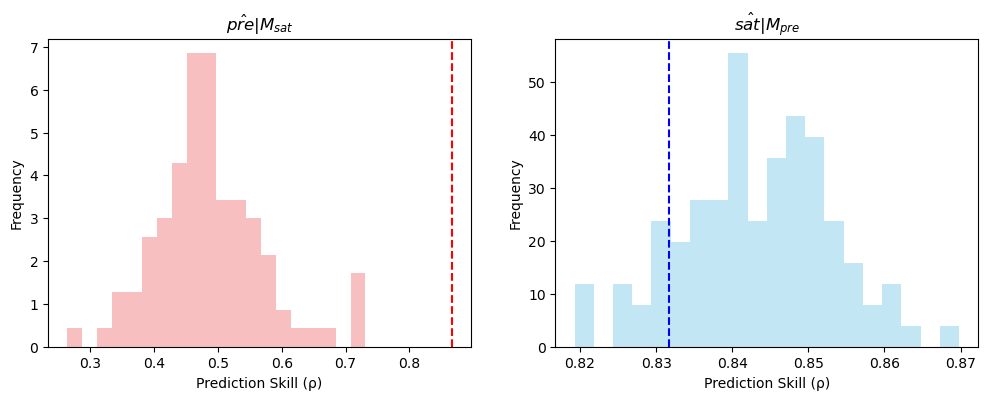

True

In [ ]:
result = ccm_significance_test(ccm_out, ensemble_ccm, if_plot=True)
result

d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


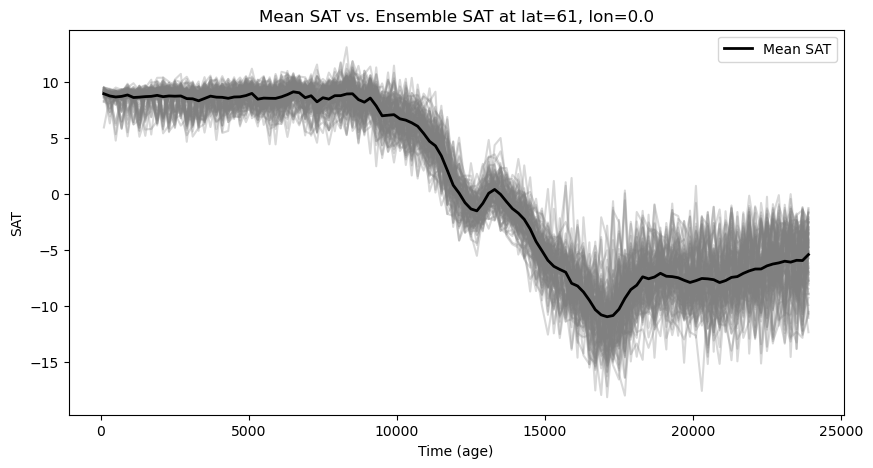

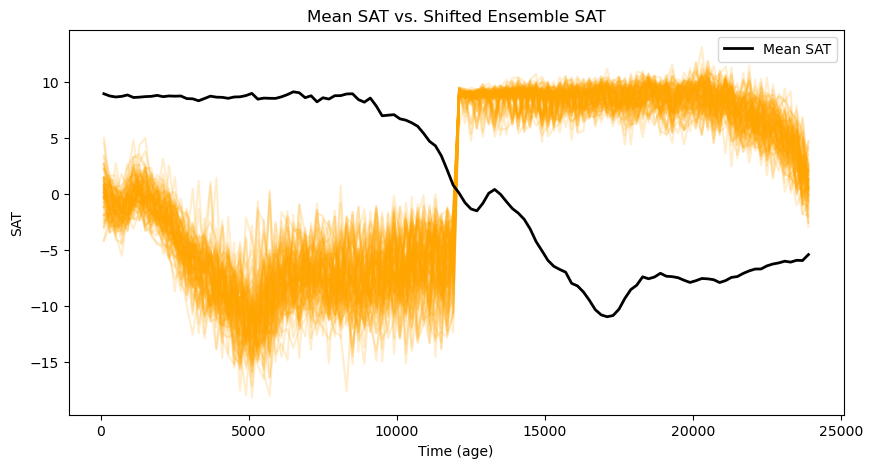

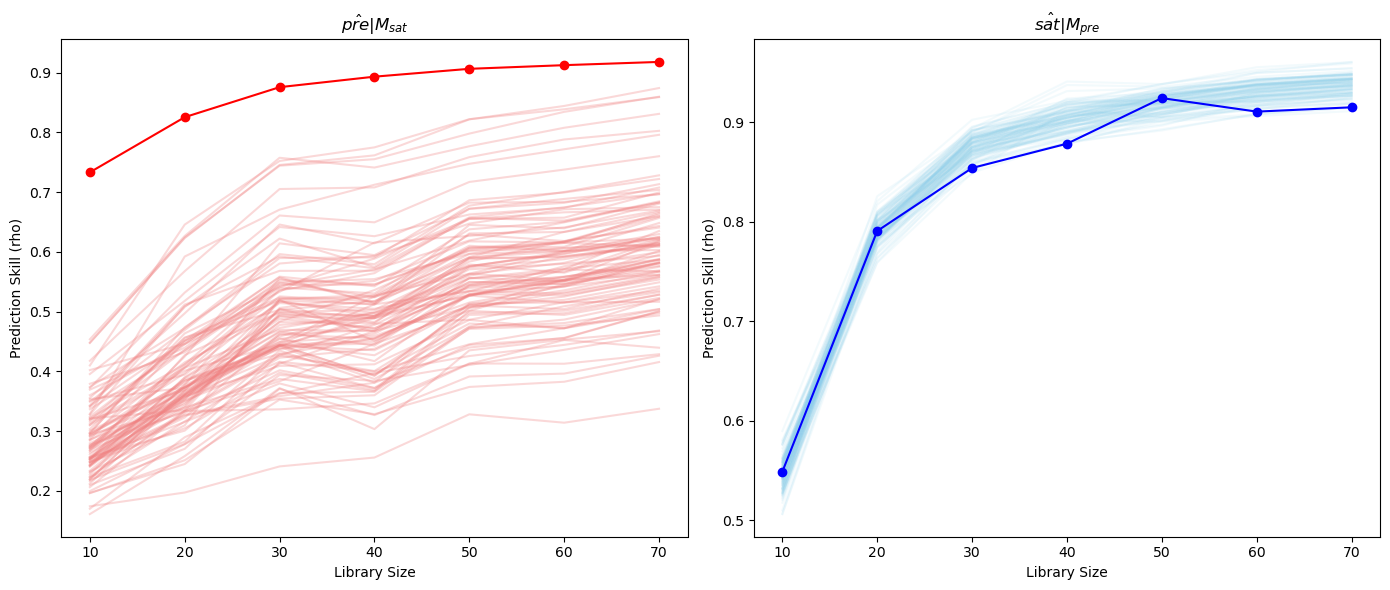

In [12]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyEDM import CCM

# ---------------------------
# Load data
# ---------------------------
ds_sat = xr.open_dataset('LGMR_data/LGMR_SAT_climo.nc')
df_pre = pd.read_csv(r"D:\VScode\Inso_LGMR\inso_data\pre.csv")
ds_sat_ens = xr.open_dataset('LGMR_data/LGMR_SAT_ens.nc')

# ---------------------------
# Select a grid point for testing
# ---------------------------
lat_idx = 80
lon_idx = 0
time = ds_sat['age'].values

# Mean SAT time series at the selected grid point
sat_mean = ds_sat['sat'].isel(lat=lat_idx, lon=lon_idx).values

# Ensemble SAT data at the same grid point (shape: nEns x time)
sat_ens = ds_sat_ens['sat'].isel(lat=lat_idx, lon=lon_idx).values

samples=100

# from sat_ens randomly select n=samples
sat_ens = sat_ens[np.random.choice(sat_ens.shape[0], samples, replace=False), :]



# generate n=sampels random age series, each age in each series is between  sat[age][i]-100 to sat[age][i]+99 
sat_age_ran=np.empty((samples,len(time)))
for i in range(samples):
    sat_age_ran[i]=np.random.randint(time-100,time+100)

# convert columns of df_pre to numpy array
pre = df_pre['pre'].values
pre_age = df_pre['age'].values  

# create a interpolated pre series for each sat_age_ran
pre_ran = np.empty((samples,len(pre_age)))
for i in range(samples):
    pre_ran[i] = np.interp(sat_age_ran[i],pre_age,pre)

# ---------------------------
# 1. (Already plotted earlier) Plot mean SAT and ensemble members
# ---------------------------
plt.figure(figsize=(10, 5))
for i in range(sat_ens.shape[0]):
    plt.plot(time, sat_ens[i, :], color='gray', alpha=0.3)
plt.plot(time, sat_mean, color='k', lw=2, label='Mean SAT')
plt.xlabel("Time (age)")
plt.ylabel("SAT")
plt.title(f"Mean SAT vs. Ensemble SAT at lat={int(ds_sat['lat'].values[lat_idx])}, lon={ds_sat['lon'].values[lon_idx]}")
plt.legend()
plt.show()

# ---------------------------
# 2. Create shifted ensemble data
# ---------------------------
nTime = len(time)
half = nTime // 2
sat_ens_shifted = np.empty_like(sat_ens)
for i in range(sat_ens.shape[0]):
    ts = sat_ens[i, :]
    shifted_ts = np.concatenate((ts[half:], ts[:half]))
    sat_ens_shifted[i, :] = shifted_ts

plt.figure(figsize=(10, 5))
for i in range(sat_ens_shifted.shape[0]):
    plt.plot(time, sat_ens_shifted[i, :], color='orange', alpha=0.2)
plt.plot(time, sat_mean, color='k', lw=2, label='Mean SAT')
plt.xlabel("Time (age)")
plt.ylabel("SAT")
plt.title("Mean SAT vs. Shifted Ensemble SAT")
plt.legend()
plt.show()

# ---------------------------
# 3. Set CCM parameters and run CCM (one call returns both directions)
# ---------------------------
E_val = 4
tau_val = 3
Tp_val = 0
libSizes = "10 20 30 40 50 60 70"

# Prepare a common DataFrame for the mean SAT and pre data
df_ccm = pd.DataFrame({
    'Time': time,
    'X': sat_mean,
    'Y': df_pre['pre'].values
})
# Run CCM once: X is SAT and Y is pre. We assume the output DataFrame contains both "X:Y" and "Y:X"
ccm_out = CCM(
    dataFrame   = df_ccm,
    E           = E_val,
    tau         = tau_val,
    columns     = "X",   # SAT manifold
    target      = "Y",   # predict pre
    libSizes    = libSizes,
    sample      = 10,
    random      = True,
    replacement = False,
    Tp          = Tp_val
)

# For each ensemble member (shifted), compute CCM in the same way
ensemble_ccm = []
for i in range(sat_ens_shifted.shape[0]):
    df_temp = pd.DataFrame({
        'Time': time,
        'X': sat_ens_shifted[i, :],
        'Y': pre_ran[i]
    })
    try:
        out = CCM(
            dataFrame   = df_temp,
            E           = E_val,
            tau         = tau_val,
            columns     = "X",
            target      = "Y",
            libSizes    = libSizes,
            sample      = 10,
            random      = True,
            replacement = False,
            Tp          = Tp_val
        )
        ensemble_ccm.append(out)
    except Exception as e:
        print(f"Error in ensemble member {i}: {e}")

# ---------------------------
# 4. Plot the CCM curves in a subplot with two panels using the two output columns
# ---------------------------
fig, axes = plt.subplots(ncols=2, figsize=(14, 6))

# --- Left subplot: SAT -> pre (use "X:Y") ---
ax = axes[0]
for i, out in enumerate(ensemble_ccm):
    label = 'Ensemble SAT CCM' if i == 0 else None
    ax.plot(out['LibSize'], out['X:Y'], color='lightcoral', linestyle='-', alpha=0.3, label=label)
ax.plot(ccm_out['LibSize'], ccm_out['X:Y'], 'ro-', label='Mean SAT CCM')
ax.set_xlabel("Library Size")
ax.set_ylabel("Prediction Skill (rho)")
ax.set_title(r'$\hat{pre}|M_{sat}$')
# ax.legend()

# --- Right subplot: pre -> SAT (use "Y:X") ---
ax2 = axes[1]
for i, out in enumerate(ensemble_ccm):
    label = 'Ensemble pre CCM' if i == 0 else None
    ax2.plot(out['LibSize'], out['Y:X'], color='skyblue', linestyle='-', alpha=0.1, label=label)
ax2.plot(ccm_out['LibSize'], ccm_out['Y:X'], 'bo-', label='Mean pre CCM')
ax2.set_xlabel("Library Size")
ax2.set_ylabel("Prediction Skill (rho)")
ax2.set_title(r'$\hat{sat}|M_{pre}$')
# ax2.legend()

plt.tight_layout()
plt.show()


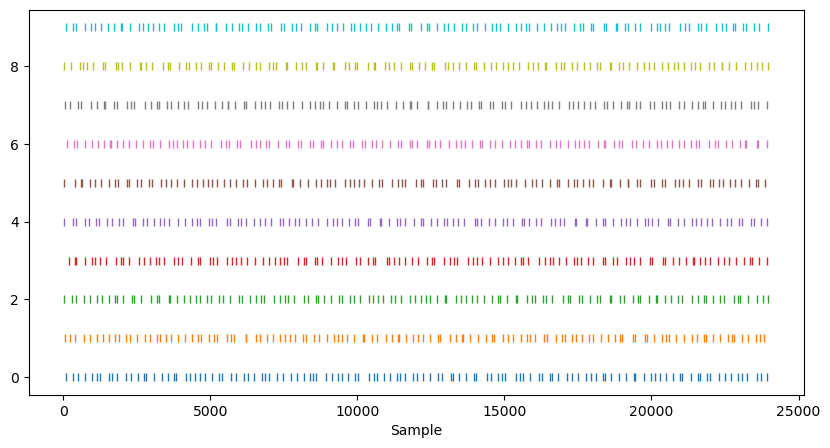

In [ ]:
samples=10
sat_age_ran=np.empty((samples,len(sat_age)))
for i in range(samples):
    sat_age_ran[i]=np.random.randint(sat_age-100,sat_age+100)

# visualize sat_age_ran, for each column, plot the value as vertical lines in the x-axis
plt.figure(figsize=(10,5))
plt.plot(sat_age_ran.T,np.tile(np.arange(samples),(sat_age_ran.shape[1],1)),'|')
plt.xlabel('Sample')


# convert columns of df_pre to numpy array
pre = df_pre['pre'].values
pre_age = df_pre['age'].values  

# create a interpolated pre series for each sat_age_ran
pre_ran = np.empty((samples,len(pre_age)))
for i in range(samples):
    pre_ran[i] = np.interp(sat_age_ran[i],pre_age,pre)


# # plot all pre_ran
# plt.figure(figsize=(10,5))
# plt.plot(sat_age_ran.T,pre_ran.T)
# plt.xlabel('Sample')
